### 1. Importing library

In [5]:
import os, math
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error ## MSE
from sklearn.metrics import r2_score ## R2
from sklearn.model_selection import KFold

import tensorflow as tf
print(tf.__version__)

import warnings
warnings.simplefilter("ignore")
# # change cell width
# from IPython.core.display import display, HTML
# display(HTML("<style>.container { width:80% !important; }</style>"))

2.6.0


In [6]:
# gpus = tf.config.experimental.list_physical_devices('GPU')
# if gpus:
#     try:
#         # Currently, memory growth needs to be the same across GPUs
#         for gpu in gpus:
#             tf.config.experimental.set_memory_growth(gpu, True)
#         logical_gpus = tf.config.experimental.list_logical_devices('GPU')
#         print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
#     except RuntimeError as e:
#         # Memory growth must be set before GPUs have been initialized
#         print(e)

### 2. Importing & cleansing raw data

In [7]:
data_dir = r'/content/drive/MyDrive/Colab Notebooks/CGH/AID3 (AID Phase 2) [20-Sep-21 to 10-Dec-21]/DataForLICV4122'
data_filelist = os.listdir(data_dir)
file_num = len(data_filelist)
print("file_no.:",file_num)
print("file_name:",*data_filelist, sep="\n")

# Read Data and Integrate into 1 Data Frame
df_raw = pd.DataFrame()
for i_file in range(file_num):
    file_dir = data_dir + "/" + data_filelist[i_file]
    print(file_dir)
    df_tmp = pd.read_pickle(file_dir)
    df_raw = pd.concat([df_raw, df_tmp])
print("df_raw.shape:", df_raw.shape)

file_no.: 2
file_name:
Data_for_LICV4122_02.pkl
Data_for_LICV4122_01.pkl
/content/drive/MyDrive/Colab Notebooks/CGH/AID3 (AID Phase 2) [20-Sep-21 to 10-Dec-21]/DataForLICV4122/Data_for_LICV4122_02.pkl
/content/drive/MyDrive/Colab Notebooks/CGH/AID3 (AID Phase 2) [20-Sep-21 to 10-Dec-21]/DataForLICV4122/Data_for_LICV4122_01.pkl
df_raw.shape: (27360, 126)


In [8]:
df = df_raw.copy()
df.dropna(inplace=True)
df #Checking raw data

,TI_4124.PV,LA_4104.PV,LC_4103.PV,LC_4105.PV,LC_4105.OP,PC_4108.PV,TI_4127.PV,LC_4109.PV,TI_4128.PV,FI_4118.PV,TI_4132.PV,FI_4119.PV,TI_4131.PV,LC_4119.PV,TI_4133.PV,FC_4136.PV,SC-4115,FI_4120.PV,LC_4120.PV,LC_4121.PV,TI_4134.PV,SC_4108.GF,SC_4108.H6,SC_4108.H7,SC_4108.HH,TI_4190.PV,PC_4111.PV,PC_4111.OP,TI_4135.PV,TI_4165.PV,TI_4152.PV,TI_4164.PV,TI_4159.PV,TI_4160.PV,TI_4163.PV,TI_4136.PV,TI_4140.PV,TC_4120.PV,TI_4137.PV,TI_4138.PV,...,SC_4112.FC,SC_4112.FF,SC_4112.FI,SC_4112.FL,SC_4112.FO,SC_4112.FR,SC_4112.MI,SC_4112.ML,SC_4112.MM,SC_4112.MN,FC_4132.PV,FSI4170.PV,FSI4133.PV,TI_4150.PV,LC_4122.OP,TI_4101.PV,PD_4101.PV,FI_4117.PV,HC_4105.OP,LC_4101.PV,LC_4101.OP,TI_4102.PV,FSI4101.PV,PC_4102.PV,LIX41022.PV,LIX41023.PV,FS-4101-1.PV,TA_4137.PV,LICA-4126.PV,AI_41021.PV,AI_41022.PV,FI_4134.PV,FSI4135.PV,TI_4151.PV,PCX4129.PV,PQ_62003.PV,PQ_62004.PV,FC_61001.PV,HC_4113.OP,TI_4191.PV
2021-01-06 12:00:00.003,192.039111,No Data,50.015868,50.054942,73.926023,0.754260,30.698971,54.8767,32.934088,1.764795,176.979192,12.881115,137.085299,48.650832,188.198456,2.753863,No Data,633.338914,50.007877,40.719132,33.754734,43.299999,0.95,27.299999,3.5,212.551298,0.443820,90.945305,297.855024,306.779803,293.792671,583.329902,402.335555,396.289284,654.233488,352.538622,347.612254,348.149847,348.391113,344.156715,...,413.5,438.0,463.0,492.5,526.0,526.5,11.0,1.5,6.1,8,36.007738,0,35.354050,23.794540,68.678070,77.58437,0.127829,0.0,100,59.980960,77.394588,167.442403,325.565683,0.198746,100.0,100.0,No Data,[-11059] No Good Data For Calculation,No Data,0.242626,903.360012,274.501162,281.730884,72.516382,1.158850,16.052974,0.0,0.0,13.999874,113.330084
2021-01-06 12:01:00.003,192.143439,No Data,50.016703,50.032037,73.922797,0.754030,30.699176,54.7977,32.942510,1.731745,177.003154,13.012254,137.079682,48.584659,188.259884,2.748331,No Data,632.312607,50.005010,40.634352,33.743824,43.299999,0.95,27.299999,3.5,212.551921,0.442550,90.745028,297.876465,306.729795,294.061182,583.596418,402.371920,396.309739,652.959027,352.612752,347.813598,348.324610,348.497090,344.379355,...,413.5,438.0,463.0,492.5,526.0,526.5,11.0,1.5,6.1,8,36.046559,0,35.358090,23.706602,68.553498,77.58538,0.136065,0.0,100,59.899177,77.276471,167.434436,325.489843,0.198537,100.0,100.0,No Data,[-11059] No Good Data For Calculation,No Data,0.241984,903.325723,274.004838,281.581960,72.351931,1.161250,16.129151,0.0,0.0,13.999874,113.320957
2021-01-06 12:02:00.003,192.247768,No Data,50.017537,50.009133,73.919571,0.753801,30.699381,54.7187,32.950933,1.681566,177.027116,13.089134,137.074065,48.666570,188.307346,2.745973,No Data,631.257719,50.002144,40.452179,33.741095,43.299999,0.95,27.299999,3.5,212.552544,0.441946,90.544751,297.881829,306.679787,294.351156,583.862933,402.408286,396.330193,652.996869,352.718654,348.089101,348.522757,348.682525,344.665594,...,413.5,438.0,463.0,492.5,526.0,526.5,11.0,1.5,6.1,8,36.069619,0,35.378977,23.610421,68.428926,77.58639,0.144301,0.0,100,59.817393,77.158354,167.426468,325.395533,0.198327,100.0,100.0,No Data,[-11059] No Good Data For Calculation,No Data,0.240137,903.291434,273.387879,281.290217,72.211362,1.163651,16.169294,0.0,0.0,13.999874,113.311829
2021-01-06 12:03:00.003,192.352097,No Data,50.018372,49.986228,73.916345,0.753572,30.699586,54.6396,32.959356,1.602392,177.051077,13.070562,137.068448,48.748480,188.318512,2.748006,No Data,630.202831,49.999278,40.270007,33.702903,43.299999,0.95,27.299999,3.5,212.553167,0.441532,90.344474,297.956909,306.629779,294.641074,584.129448,402.444651,396.350647,653.034711,352.962256,348.226860,348.724085,348.799082,344.951822,...,413.5,438.0,463.0,492.5,526.0,526.5,11.0,1.5,6.1,8,36.070622,0,35.439515,23.549962,68.304354,77.58740,0.152537,0.0,100,59.735610,77.041164,167.418500,325.191182,0.198118,100.0,100.0,No Data,[-11059] No Good Data For Calculation,No Data,0.238197,903.257146,272.550505,280.617393,72.105275,1.166051,16.195562,0.0,0.0,13.999874,113.302701
2021-01-06 12:04:00.003,192.456425,No Data,50.019207,49.963324,

In [9]:
# explanatory/Input & Output variable - given
list_x = [
    'FC_4121.PV',
    'FC_4137.PV',
    'TI_4144.PV',
    'PC_4112.PV',
    'FC_4125.PV',
    'FC_4126.PV',
    'LC_4122.PV',
    'FI_4117.PV',
    'AI_41022.PV',
    'FSI4135.PV',
    'TI_4151.PV',
    'PCX4129.PV',
    'HC_4113.OP',
    'LC_4122.OP' #Target Variable 
]

# Target/Output variable
list_y = [
    'LC_4122.OP' 
]

In [10]:
df_tags = df[list_x]
df_tags

,FC_4121.PV,FC_4137.PV,TI_4144.PV,PC_4112.PV,FC_4125.PV,FC_4126.PV,LC_4122.PV,FI_4117.PV,AI_41022.PV,FSI4135.PV,TI_4151.PV,PCX4129.PV,HC_4113.OP,LC_4122.OP
2021-01-06 12:00:00.003,86.409064,5.593698,333.616774,0.071545,44.162644,42.029026,49.253565,0.0,903.360012,281.730884,72.516382,1.158850,13.999874,68.678070
2021-01-06 12:01:00.003,86.341717,5.591818,333.638000,0.071832,44.195685,42.035635,49.141454,0.0,903.325723,281.581960,72.351931,1.161250,13.999874,68.553498
2021-01-06 12:02:00.003,86.274370,5.590812,333.638000,0.072075,44.207395,42.044307,49.029342,0.0,903.291434,281.290217,72.211362,1.163651,13.999874,68.428926
2021-01-06 12:03:00.003,86.207022,5.591022,333.638000,0.072314,44.189693,42.055782,48.917230,0.0,903.257146,280.617393,72.105275,1.166051,13.999874,68.304354
2021-01-06 12:04:00.003,86.139675,5.592123,333.643310,0.072608,44.161926,42.053070,48.806547,0.0,903.222857,279.749582,72.012450,1.168452,13.999874,68.179781
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-01-06 11:55:00.003,86.745800,5.597932,333.446930,0.070336,44.108755,42.045722,49.814124,0.0,904.843422,292.628956,73.545900,1.146848,13.999874,69.300932
2021-01-06 11:56:00.003,86.678453,5.595490,333.446930,0.070576,44.145152,42.049208,49.702012,0.0,904.304982,283.177685,73.137206,1.149248,13.999874,69.176359
2021-01-06 11:57:00.003,86.611106,5.593369,333.446930,0.070783,44.146455,42.033271,49.589901,0.0,903.589730,282.820498,73.004532,1.151649,13.999874,69.051787
2021-01-06 11:58:00.003,86.543758,5.592637,333.452239,0.071016,44.147429,42.024454,49.477789,0.0,903.428589,282.704544,72.946158,1.154049,13.999874,68.927215


In [11]:
# change "string" to "NaN"
df_removeString = []
for col in df_tags.columns[:]:
    remove_string = pd.to_numeric(df_tags[col], errors='coerce')
    df_removeString.append(remove_string)
    
pd.DataFrame(df_removeString).T

,FC_4121.PV,FC_4137.PV,TI_4144.PV,PC_4112.PV,FC_4125.PV,FC_4126.PV,LC_4122.PV,FI_4117.PV,AI_41022.PV,FSI4135.PV,TI_4151.PV,PCX4129.PV,HC_4113.OP,LC_4122.OP
2021-01-06 12:00:00.003,86.409064,5.593698,333.616774,0.071545,44.162644,42.029026,49.253565,0.0,903.360012,281.730884,72.516382,1.158850,13.999874,68.678070
2021-01-06 12:01:00.003,86.341717,5.591818,333.638000,0.071832,44.195685,42.035635,49.141454,0.0,903.325723,281.581960,72.351931,1.161250,13.999874,68.553498
2021-01-06 12:02:00.003,86.274370,5.590812,333.638000,0.072075,44.207395,42.044307,49.029342,0.0,903.291434,281.290217,72.211362,1.163651,13.999874,68.428926
2021-01-06 12:03:00.003,86.207022,5.591022,333.638000,0.072314,44.189693,42.055782,48.917230,0.0,903.257146,280.617393,72.105275,1.166051,13.999874,68.304354
2021-01-06 12:04:00.003,86.139675,5.592123,333.643310,0.072608,44.161926,42.053070,48.806547,0.0,903.222857,279.749582,72.012450,1.168452,13.999874,68.179781
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-01-06 11:55:00.003,86.745800,5.597932,333.446930,0.070336,44.108755,42.045722,49.814124,0.0,904.843422,292.628956,73.545900,1.146848,13.999874,69.300932
2021-01-06 11:56:00.003,86.678453,5.595490,333.446930,0.070576,44.145152,42.049208,49.702012,0.0,904.304982,283.177685,73.137206,1.149248,13.999874,69.176359
2021-01-06 11:57:00.003,86.611106,5.593369,333.446930,0.070783,44.146455,42.033271,49.589901,0.0,903.589730,282.820498,73.004532,1.151649,13.999874,69.051787
2021-01-06 11:58:00.003,86.543758,5.592637,333.452239,0.071016,44.147429,42.024454,49.477789,0.0,903.428589,282.704544,72.946158,1.154049,13.999874,68.927215


In [12]:
# remove "NaN" row
df_tags_dropna = pd.DataFrame(df_removeString).T.dropna(how="any", axis=0)
df = df_tags_dropna
df

,FC_4121.PV,FC_4137.PV,TI_4144.PV,PC_4112.PV,FC_4125.PV,FC_4126.PV,LC_4122.PV,FI_4117.PV,AI_41022.PV,FSI4135.PV,TI_4151.PV,PCX4129.PV,HC_4113.OP,LC_4122.OP
2021-01-06 12:00:00.003,86.409064,5.593698,333.616774,0.071545,44.162644,42.029026,49.253565,0.0,903.360012,281.730884,72.516382,1.158850,13.999874,68.678070
2021-01-06 12:01:00.003,86.341717,5.591818,333.638000,0.071832,44.195685,42.035635,49.141454,0.0,903.325723,281.581960,72.351931,1.161250,13.999874,68.553498
2021-01-06 12:02:00.003,86.274370,5.590812,333.638000,0.072075,44.207395,42.044307,49.029342,0.0,903.291434,281.290217,72.211362,1.163651,13.999874,68.428926
2021-01-06 12:03:00.003,86.207022,5.591022,333.638000,0.072314,44.189693,42.055782,48.917230,0.0,903.257146,280.617393,72.105275,1.166051,13.999874,68.304354
2021-01-06 12:04:00.003,86.139675,5.592123,333.643310,0.072608,44.161926,42.053070,48.806547,0.0,903.222857,279.749582,72.012450,1.168452,13.999874,68.179781
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-01-06 11:55:00.003,86.745800,5.597932,333.446930,0.070336,44.108755,42.045722,49.814124,0.0,904.843422,292.628956,73.545900,1.146848,13.999874,69.300932
2021-01-06 11:56:00.003,86.678453,5.595490,333.446930,0.070576,44.145152,42.049208,49.702012,0.0,904.304982,283.177685,73.137206,1.149248,13.999874,69.176359
2021-01-06 11:57:00.003,86.611106,5.593369,333.446930,0.070783,44.146455,42.033271,49.589901,0.0,903.589730,282.820498,73.004532,1.151649,13.999874,69.051787
2021-01-06 11:58:00.003,86.543758,5.592637,333.452239,0.071016,44.147429,42.024454,49.477789,0.0,903.428589,282.704544,72.946158,1.154049,13.999874,68.927215


### 4. Train & Trial data segregation

In [13]:
# Last 10% of data shall be Trial, and first 90% of data shall be Train
Total_Data = df.shape[0]
print('Total Data 100% => ', Total_Data)
Train_Data = Total_Data * 0.9
Train_Data = round(Train_Data)
Trial_Data = Total_Data - Train_Data
print('Train Data 90% => {} / Trial Data 10% => {}'.format(Train_Data, Trial_Data))

Total Data 100% =>  27360
Train Data 90% => 24624 / Trial Data 10% => 2736


In [14]:
# Last 10% of data shall be trial
df_trial = df[Train_Data:]
df_trial

,FC_4121.PV,FC_4137.PV,TI_4144.PV,PC_4112.PV,FC_4125.PV,FC_4126.PV,LC_4122.PV,FI_4117.PV,AI_41022.PV,FSI4135.PV,TI_4151.PV,PCX4129.PV,HC_4113.OP,LC_4122.OP
2021-01-04 14:24:00.002,86.552879,5.694447,336.694763,0.071663,43.774104,42.638009,50.141334,41.069898,925.784335,269.143685,82.264871,1.182492,1.999874,69.225169
2021-01-04 14:25:00.002,86.548634,5.696614,336.694763,0.071594,43.797411,42.669902,50.123794,41.356983,925.830699,274.014208,82.515495,1.171786,1.999874,69.249907
2021-01-04 14:26:00.002,86.544389,5.697802,336.694763,0.071625,43.805391,42.676238,50.106255,34.176373,925.877064,278.448344,82.840761,1.166492,1.999874,69.274646
2021-01-04 14:27:00.002,86.540144,5.697648,336.694763,0.071669,43.792349,42.647388,50.088716,13.784967,925.923428,281.053551,83.027414,1.180692,1.999874,69.299385
2021-01-04 14:28:00.002,86.535899,5.698447,336.694763,0.071620,43.748200,42.619814,50.071176,0.287086,925.969793,281.917536,83.160753,1.192740,1.999874,69.324124
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-01-06 11:55:00.003,86.745800,5.597932,333.446930,0.070336,44.108755,42.045722,49.814124,0.000000,904.843422,292.628956,73.545900,1.146848,13.999874,69.300932
2021-01-06 11:56:00.003,86.678453,5.595490,333.446930,0.070576,44.145152,42.049208,49.702012,0.000000,904.304982,283.177685,73.137206,1.149248,13.999874,69.176359
2021-01-06 11:57:00.003,86.611106,5.593369,333.446930,0.070783,44.146455,42.033271,49.589901,0.000000,903.589730,282.820498,73.004532,1.151649,13.999874,69.051787
2021-01-06 11:58:00.003,86.543758,5.592637,333.452239,0.071016,44.147429,42.024454,49.477789,0.000000,903.428589,282.704544,72.946158,1.154049,13.999874,68.927215


In [15]:
# First 90% of data shall be train
df_train = df[:Train_Data]
df_train

,FC_4121.PV,FC_4137.PV,TI_4144.PV,PC_4112.PV,FC_4125.PV,FC_4126.PV,LC_4122.PV,FI_4117.PV,AI_41022.PV,FSI4135.PV,TI_4151.PV,PCX4129.PV,HC_4113.OP,LC_4122.OP
2021-01-06 12:00:00.003,86.409064,5.593698,333.616774,0.071545,44.162644,42.029026,49.253565,0.000000,903.360012,281.730884,72.516382,1.158850,13.999874,68.678070
2021-01-06 12:01:00.003,86.341717,5.591818,333.638000,0.071832,44.195685,42.035635,49.141454,0.000000,903.325723,281.581960,72.351931,1.161250,13.999874,68.553498
2021-01-06 12:02:00.003,86.274370,5.590812,333.638000,0.072075,44.207395,42.044307,49.029342,0.000000,903.291434,281.290217,72.211362,1.163651,13.999874,68.428926
2021-01-06 12:03:00.003,86.207022,5.591022,333.638000,0.072314,44.189693,42.055782,48.917230,0.000000,903.257146,280.617393,72.105275,1.166051,13.999874,68.304354
2021-01-06 12:04:00.003,86.139675,5.592123,333.643310,0.072608,44.161926,42.053070,48.806547,0.000000,903.222857,279.749582,72.012450,1.168452,13.999874,68.179781
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-01-04 14:19:00.002,86.574105,5.699537,336.694763,0.072179,43.747568,42.609329,50.229030,0.000000,925.552512,275.964230,82.235542,1.188389,1.999874,69.101474
2021-01-04 14:20:00.002,86.569860,5.697922,336.694763,0.071992,43.780556,42.623685,50.211491,0.000000,925.598877,275.925385,82.238209,1.187680,1.999874,69.126213
2021-01-04 14:21:00.002,86.565615,5.692122,336.694763,0.071792,43.739701,42.618646,50.193952,0.000000,925.645241,276.604257,82.275531,1.186971,1.999874,69.150952
2021-01-04 14:22:00.002,86.561369,5.689757,336.694763,0.071747,43.726003,42.617536,50.176412,7.180610,925.691606,275.765241,82.318184,1.186263,1.999874,69.175691


In [16]:
train_index, trial_index = df_train.index, df_trial.index
print('** train = {} / trial = {}'.format(len(train_index),len(trial_index)))

** train = 24624 / trial = 2736


In [17]:
df_trial_X = df_trial.drop(columns=list_y)
df_trial_y = df_trial[list_y]

In [18]:
df_train_X = df_train.drop(columns=list_y)
df_train_y = df_train[list_y]

### 5. Execute Random Forest Learning

In [19]:
def cross_validate(data,label, tree_qty, depth, X_exp): #(train_X, train_y)

    skf = KFold(n_splits=5,random_state=1, shuffle = True)

    models = []
    train_scores = []
    validation_scores = []

    for train_index, val_index in skf.split(data,label): # Split train data
    
        train_data=data[train_index]       
        train_label=label[train_index]       
        val_data=data[val_index]
        val_label=label[val_index]
        
        rgr=RandomForestRegressor(n_estimators=tree_qty, max_depth=depth, random_state=1)
        
        from pprint import pprint
        # Look at parameters used by our current forest
        print('Parameters currently in use:\n')
        pprint(rgr.get_params())
  
        rgr.fit(train_data, train_label) # develop prediction model
        models.append(rgr)
        
        train_score = rgr.score(train_data, train_label)
        train_scores.append(train_score)
        
        validation_score= rgr.score(val_data, val_label)  
        validation_scores.append(validation_score)
        
        # Feature Importance
        fti = rgr.feature_importances_

        # save Feature Importance
        ImporTable=pd.concat([pd.DataFrame(X_exp.T.index),pd.DataFrame(fti)],axis=1)
        ImporTable.to_csv('00_RF_Importance.csv')

        # edit Feature Importance
        ImporTable.columns = [0,1]
        ImporTable_ = ImporTable.set_index(0)
        ImporTable_ = ImporTable_.sort_values(1,ascending=True)

        ImporTable_Y = ImporTable_.iloc[:,0][-63:]
        ImporTable_X = np.arange(len(ImporTable_Y))

        plt.figure(figsize=(10, 25))

        label_ = ImporTable_Y.index
        
        # visualize Feature Importance
        plt.title(
                  "train_score = "+("{:.4f}".format(train_score))+"\n"
                  "validation_score = "+("{:.4f}".format(validation_score))+"\n"
                  "feature_importance")
        plt.barh(ImporTable_X, ImporTable_Y, align="center",tick_label=label_, linewidth=0.1)   # bar chart
        plt.yticks(ImporTable_X, ImporTable_.index)  # x-axis label
        plt.grid()
        plt.show()
        
    # visualize "train_score VS validation_score"
    fig, ax1 = plt.subplots(figsize=(3, 3))
    x = list(range(len(models)))

    ax1.plot(x, train_scores,"-",label="train_scores", lw=1, marker='o', markersize=2, markeredgewidth=4) ## 系列１をプロット
    ax1.plot(x, validation_scores,"-",label="validation_scores", alpha=0.8, lw=1, marker='o', markersize=2, markeredgewidth=4) # 系列２をプロット
    ax1.set_title('train_score vs validation_score')
    ax1.set_xlabel('model ID')
    ax1.set_ylabel('score')
    ax1.legend(loc='lower left', bbox_to_anchor=(1, 0))
    ax1.grid()

    plt.show()
  
    return models

Parameters currently in use:

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': 100,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 10,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 1,
 'verbose': 0,
 'warm_start': False}


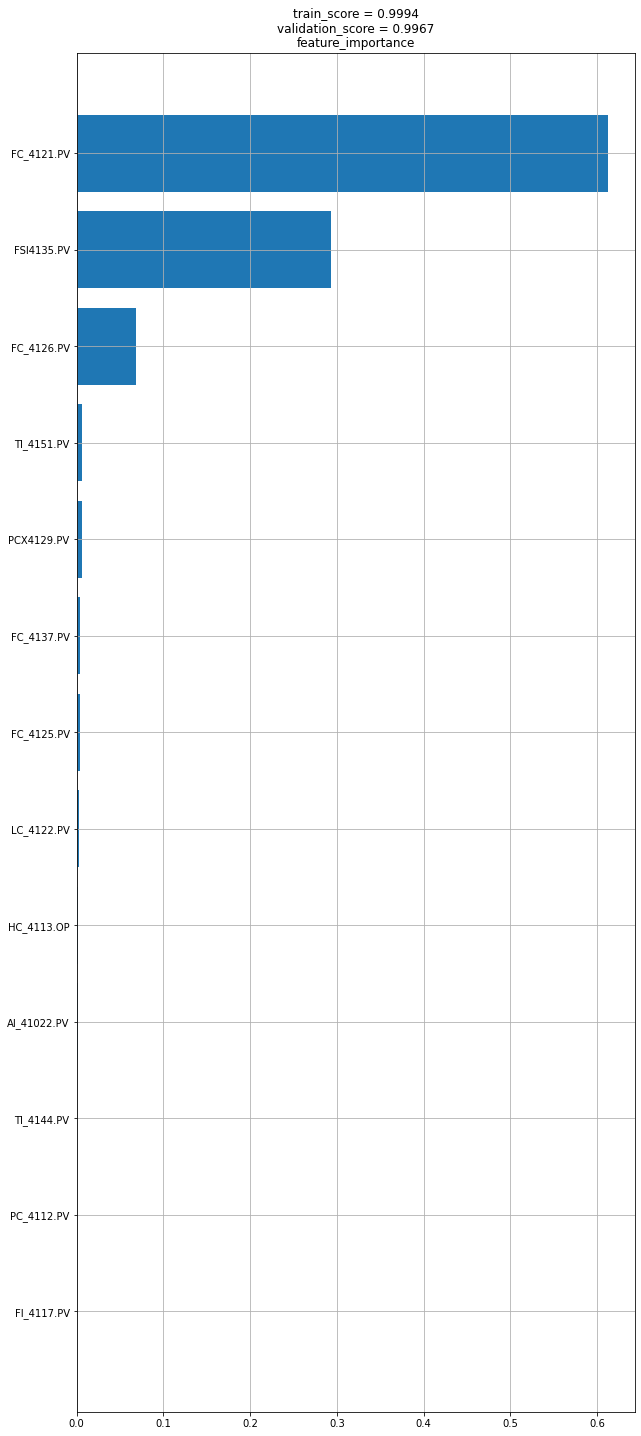

Parameters currently in use:

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': 100,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 10,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 1,
 'verbose': 0,
 'warm_start': False}


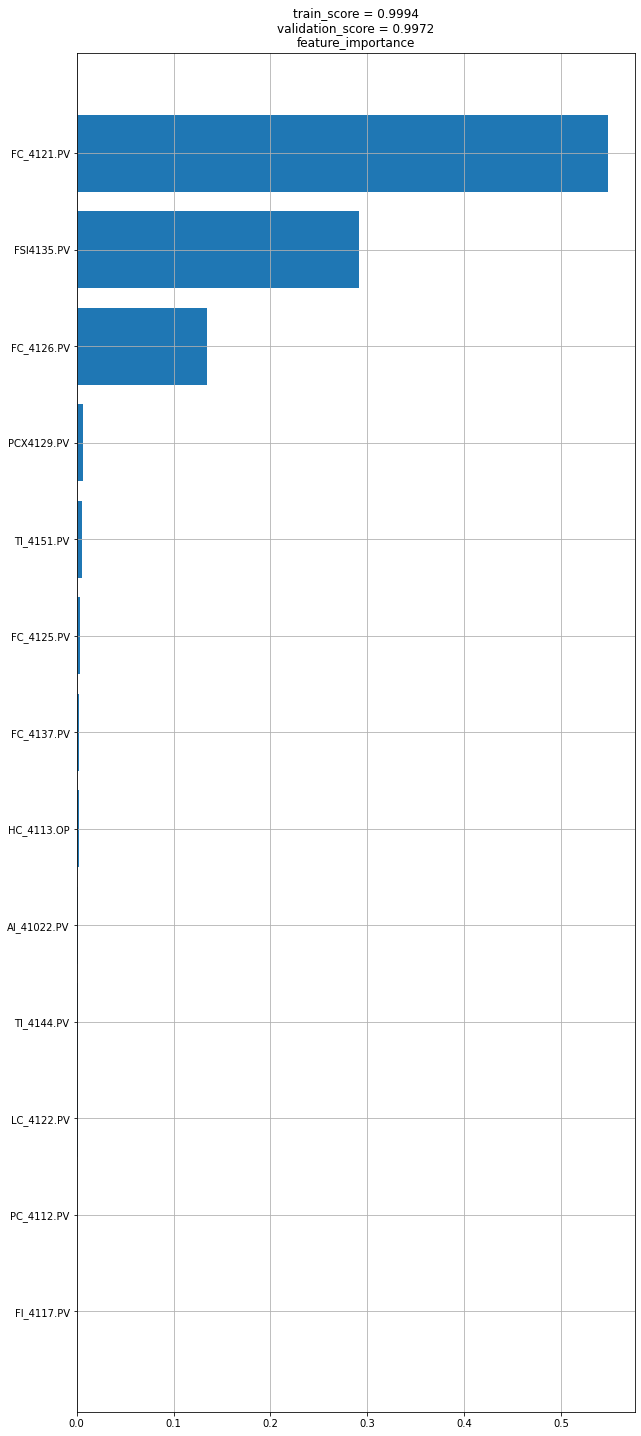

Parameters currently in use:

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': 100,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 10,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 1,
 'verbose': 0,
 'warm_start': False}


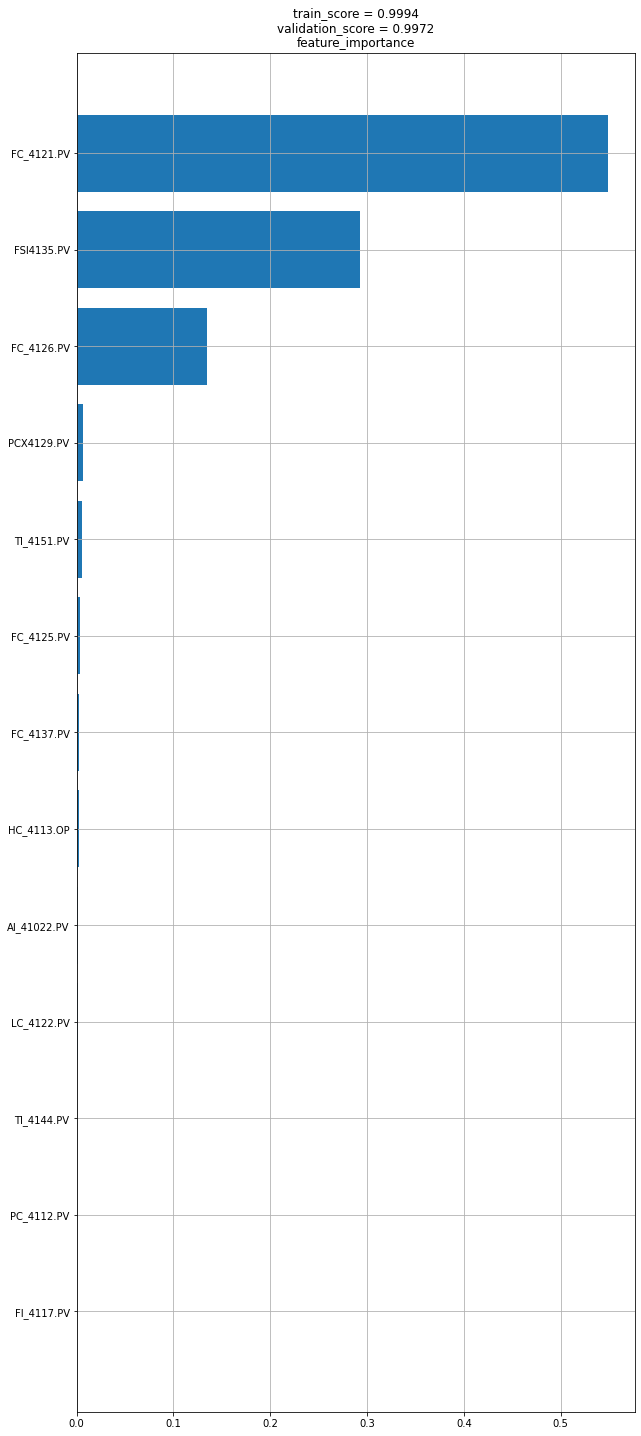

Parameters currently in use:

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': 100,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 10,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 1,
 'verbose': 0,
 'warm_start': False}


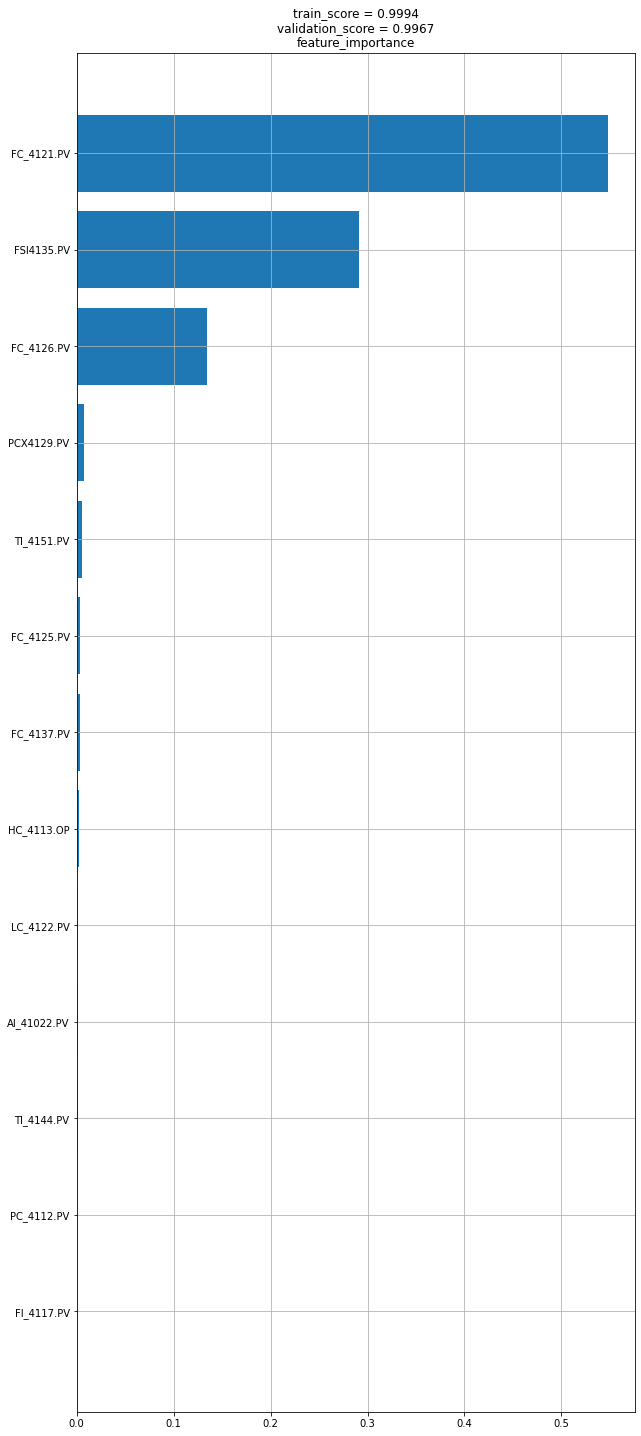

Parameters currently in use:

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': 100,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 10,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 1,
 'verbose': 0,
 'warm_start': False}


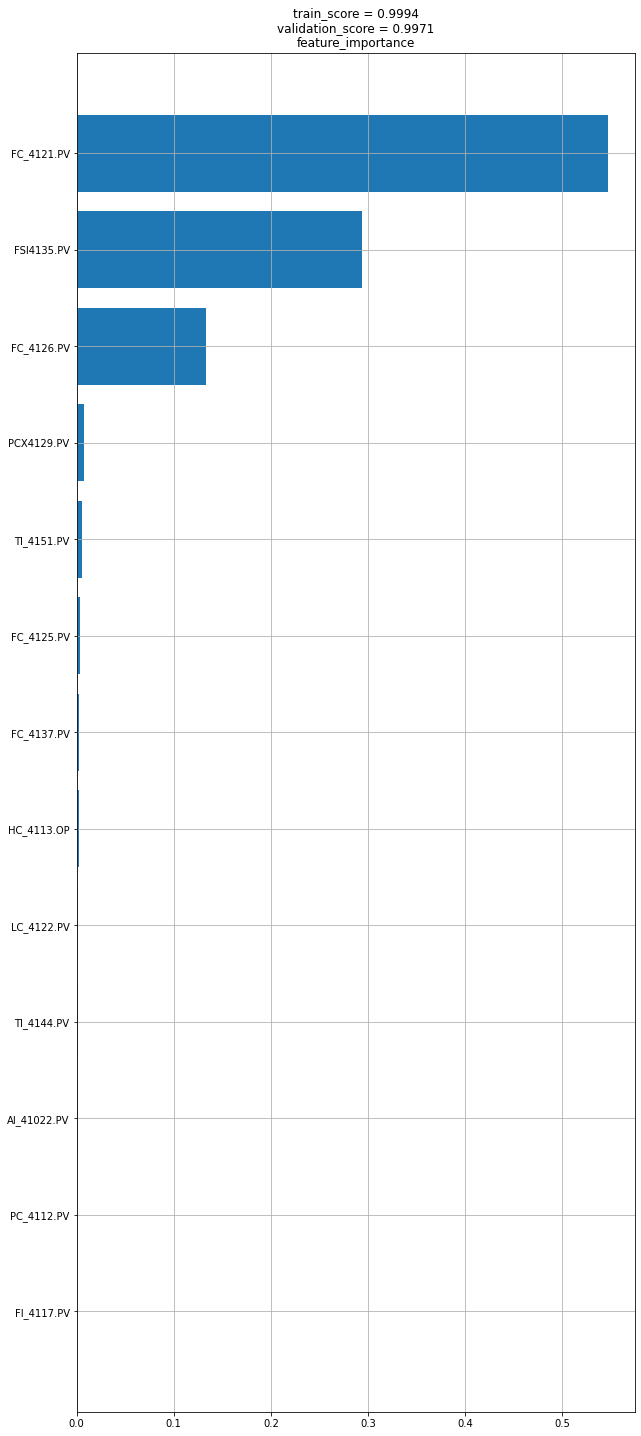

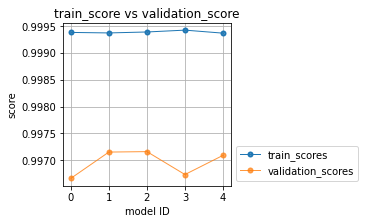

In [20]:
models = cross_validate(df_train_X.values, df_train_y.values, 10, 100, df_train_X)

In [21]:
# output ensemble mean value from rach models developed by cross-validation
def def_pred_ensemble(model, df_trial):
    sum_predictedValue = 0
    for i in range(len(model)):
        sum_predictedValue = sum_predictedValue + model[i].predict(df_trial)

    pred_ensemble = sum_predictedValue/len(model)
    return pred_ensemble

In [22]:
pred_ensemble = def_pred_ensemble(models, df_trial_X)
pred_ensemble

array([69.14783669, 69.29623308, 69.69816511, ..., 68.21790265,
       68.28097063, 68.29904198])

In [23]:
from sklearn.metrics import r2_score

# output R2 score of rach models developed by cross-validation
def def_score_ensemble(model, df_trial_X, df_trial_y):
    for i in range(len(model)):
        print("model_"+ '{}'.format(i) +" "+ "score:", "{:.3f}".format(model[i].score(df_trial_X,df_trial_y)))
    
    score_predictedEnsemble = r2_score(def_pred_ensemble(models, df_trial_X),df_trial_y)
    print('ensemble score: {:.3f}'.format(score_predictedEnsemble))
    return score_predictedEnsemble

In [24]:
print("R2 Score for Trial Dataset")
score_predictedEnsemble = def_score_ensemble(models, df_trial_X, df_trial_y)

R2 Score for Trial Dataset
model_0 score: -1.370
model_1 score: -1.950
model_2 score: -1.787
model_3 score: -1.692
model_4 score: -1.972
ensemble score: -3.405


In [25]:
x = df_trial_X.index

trial_score:-3.405
RMSE: 4.508


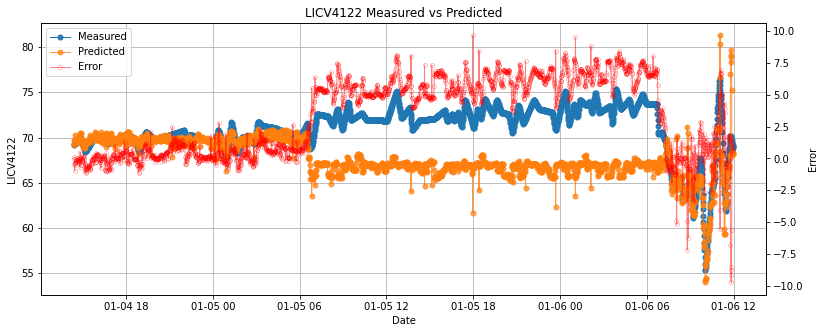

In [26]:
#fig, ax1 = plt.subplots(figsize=(500, 5))
fig, ax1 = plt.subplots(figsize=(13, 5))
ax2 = ax1.twinx()

ax1.plot(x, df_trial_y.values.reshape(-1,1),"-",label="Measured", lw=1, marker='o', markersize=2, markeredgewidth=4)
ax1.plot(x, pred_ensemble,"-",label="Predicted", alpha=0.8, lw=1, marker='o', markersize=2, markeredgewidth=4)
ax2.plot(x, df_trial_y.values.reshape(-1,1) - pred_ensemble.reshape(-1,1),"-r",label="Error", alpha=0.5, lw=1, marker='o', markersize=0.5, markeredgewidth=4)

ax1.set_title('LICV4122 Measured vs Predicted')
ax1.set_xlabel('Date')
ax1.set_ylabel('LICV4122')
ax2.set_ylabel('Error')
ax1.grid()

lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines1 + lines2, labels1 + labels2, loc="best")

print("trial_score:{:.3f}".format(score_predictedEnsemble))
print('RMSE: %.3f' % np.sqrt(mean_squared_error(df_trial_y, pred_ensemble)))